In [3]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [4]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [5]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [6]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [7]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [8]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [19]:
class ARIMAForecast(object):
    
    def __init__(self, df, percentage_train_size, periodicity):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.periodicity = periodicity 
        
    def perform(self):
        
        best_params, train_size, y_train_predict = self.grid_search_model()
                
        array_pred = np.array([])
        
        date_test = self.df[train_size:].index
        count = 0
        
        for current_datetime in date_test:

            pred = self.prediction(best_params = best_params, current_datetime = current_datetime)
            array_pred = np.append(array_pred, pred)
#             print('current_datetime ->', current_datetime)
#             print('pred ->', pred)
#             print('---')
            count += 1
            print(count/len(date_test)*100)

        print('---')

        date_train = self.df[:train_size].index
#         date_train = y_train_predict.index
        y_train = self.df[:train_size]['Close'].values
        
        date_test = self.df[train_size:].index
        y_test = self.df[train_size:]['Close'].values
        
        data_train = {
          'date_train': date_train,
          'y_train': y_train,
#           'y_train_predict': y_train_predict.values
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test,
            'y_test_predict': array_pred
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_test['y_test'],
                                                                        df_test['y_test_predict'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)

        
        return df_train, df_test
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_params, current_datetime):
        
        p = best_params['p_order']
        d = best_params['d_order']
        q = best_params['q_order']

        if self.periodicity == '1_day':
            train_datetime = (current_datetime - pd.Timedelta(days = 1))

        if self.periodicity == '1_hour':
            train_datetime = (current_datetime - pd.Timedelta(hours = 1))

        model = sm.tsa.statespace.SARIMAX(self.df[:train_datetime], order = (p, d, q), initialization='approximate_diffuse')
        fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)
        
        pred = fit_model.predict(start = current_datetime, end = current_datetime)
#         print('train_datetime ->', train_datetime)
#         print('self.df[:train_datetime] ->', self.df[:train_datetime].index[-1])
        
        return pred
        
    def grid_search_model(self):
        
        train_size = int(len(self.df) * self.percentage_train_size)
        
        best_aic = np.inf 
        best_params = None
        best_fit = None
        
        p_range = range(6)
        q_range = range(6)
        d_range = range(3) # [0,1,2]

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    try:
                        model = sm.tsa.statespace.SARIMAX(self.df[:train_size], order=(p, d, q), initialization='approximate_diffuse')

                        fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)

                        if fit_model.aic < best_aic:

                            best_aic = fit_model.aic
                            best_params = {'p_order': p, 'd_order': d, 'q_order': q}
                            best_fit = fit_model

                    except: continue

        print('AIC', best_aic, 'best_params', best_params)
        
        y_train_predict = best_fit.fittedvalues
        
        return best_params, train_size, y_train_predict

In [20]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

arima_forecast = ARIMAForecast(df = df,
                         percentage_train_size = 0.80,
                         periodicity = '1_day'
                        )
df_train, df_test = arima_forecast.perform()

AIC 18635.942217720934 best_params {'p_order': 5, 'd_order': 0, 'q_order': 4}
0.30303030303030304
0.6060606060606061
0.9090909090909091
1.2121212121212122
1.5151515151515151
1.8181818181818181
2.1212121212121215
2.4242424242424243
2.727272727272727
3.0303030303030303
3.3333333333333335
3.6363636363636362
3.939393939393939
4.242424242424243
4.545454545454546
4.848484848484849
5.151515151515151
5.454545454545454
5.757575757575758
6.0606060606060606
6.363636363636363
6.666666666666667
6.969696969696971
7.2727272727272725
7.575757575757576
7.878787878787878
8.181818181818182
8.484848484848486
8.787878787878787
9.090909090909092
9.393939393939393
9.696969696969697
10.0
10.303030303030303
10.606060606060606
10.909090909090908
11.212121212121213
11.515151515151516
11.818181818181818
12.121212121212121
12.424242424242424
12.727272727272727
13.030303030303031
13.333333333333334
13.636363636363635
13.939393939393941
14.242424242424242
14.545454545454545
14.84848484848485
15.151515151515152
15.45

In [27]:
# ARIMA 1d
# AIC 18635.942217720934 best_params {'p_order': 5, 'd_order': 0, 'q_order': 4}
# mae 269.0067 mape 3.1091 mse 169798.6015 rmse 412.0663 rmspe 5.4448 r2 0.926 pearson 0.963

In [15]:
# ARIMA 1h
# AIC 354434.78395823087 best_params {'p_order': 4, 'd_order': 1, 'q_order': 3}
# mae 43.9113 mape 0.5051 mse 6866.3785 rmse 82.8636 rmspe 1.007 r2 0.997 pearson 0.9985

In [21]:
# df_train.tail()
# df_test.head()

# df_train.to_csv('train_arima_1d.csv', sep = "\t", index = False)
df_test.to_csv('test_arima_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_arima_1d.csv', sep = "\t")
pd.read_csv('test_arima_1d.csv', sep = "\t")

# df_train.to_csv('train_arima_1h.csv', sep = "\t", index = False)
# df_test.to_csv('test_arima_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_arima_1h.csv', sep = "\t")
# pd.read_csv('test_arima_1h.csv', sep = "\t")

,date_test,y_test,y_test_predict
0,2019-05-16,7881.38,8320.881884
1,2019-05-17,7361.92,7754.740211
2,2019-05-18,7262.52,7416.697931
3,2019-05-19,8192.44,7258.976894
4,2019-05-20,8003.97,8232.219700
...,...,...,...
325,2020-04-05,6775.21,6851.008634
326,2020-04-06,7336.96,6767.771543
327,2020-04-07,7201.81,7364.961150
328,2020-04-08,7369.60,7117.558697


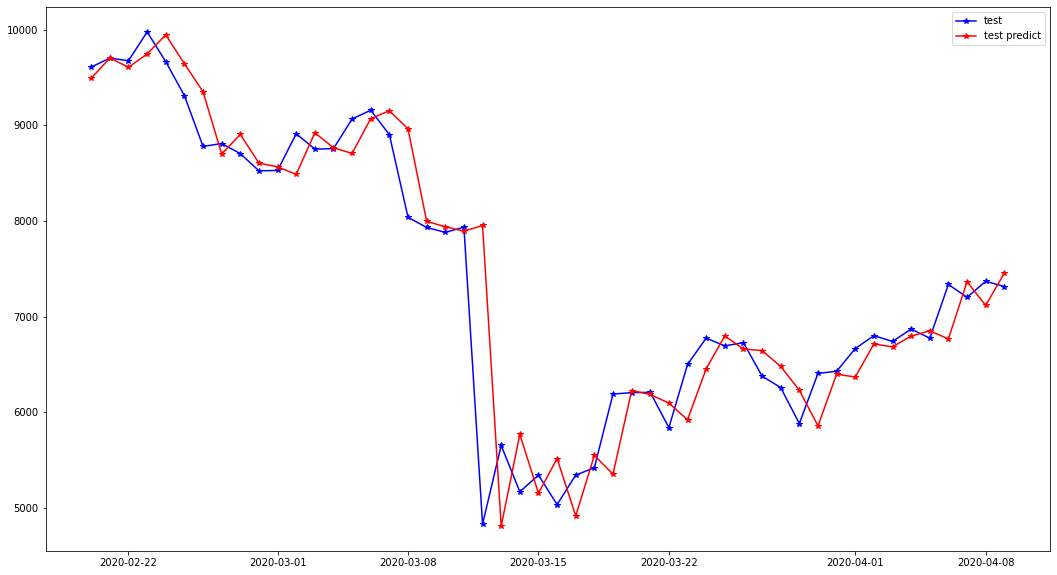

In [24]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], '*-', label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '*-', label = 'test predict', color="red")

ax.legend()
plt.show()

In [83]:
a = [2, 4, 16, 32, 64, 128, 256]
data = { 'a': a}
df_a = pd.DataFrame(data)
df_a['diff_1'] = df_a['a'].diff()
df_a['diff_2'] = df_a['diff_1'].diff()
df_a[:5]

,a,diff_1,diff_2
0,2,NaN,NaN
1,4,2.0,NaN
2,16,12.0,10.0
3,32,16.0,4.0
4,64,32.0,16.0


In [85]:
last_close_price = df_a[:5]['a'].values[-1]
before_last_close_price = df_a[:5]['a'].values[-2]
last_close_diff_price = last_close_price - before_last_close_price
pred = last_close_price + last_close_diff_price + df_a[:6]['diff_2'].values[-1]
pred

128.0

In [20]:
df = df_gemini_price_d.copy()
df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

df = df.asfreq('D') # D or H

model = sm.tsa.statespace.SARIMAX(df[:'2019-04-30'], order=(1, 2, 0))
# print(df[:'2019-04-29'].index[-1])
print(df[:'2019-04-30'].index[-1])
print(df[:'2019-04-30'].values[-1])
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False)

pred = fit_model.predict(start = '2019-04-30', end = '2019-04-30', dynamic = False)
pred

2019-04-30 00:00:00
[5266.34]


Date
2019-04-30    5137.997029
Freq: D, dtype: float64